In [62]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

In [63]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array

In [68]:

import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the path to your zip file
zip_file_path = '/content/brain_images_dataset.zip'
extracted_folder_path = '/content/extracted_dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Get the list of all images in the dataset
image_list = []
labels = []

for label in ['no', 'yes']:
    label_folder = os.path.join(extracted_folder_path, label)
    for img_file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_file)
        image_list.append(img_path)
        labels.append(label)

# Create a DataFrame
df = pd.DataFrame(list(zip(image_list, labels)), columns=['filename', 'label'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training dataset
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(240, 240),  # Adjust the target size as needed
    batch_size=32,
    class_mode='binary'
)

# Load the testing dataset
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(240, 240),
    batch_size=32,
    class_mode='binary'
)



Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [65]:
# Build the model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), input_shape=(240, 240, 3), activation='relu',padding='same', name='conv2d_8'))

# Max pooling layer 1
model.add(MaxPooling2D(pool_size=(4, 4), name='max_pooling2d_20'))

# Max pooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_21'))

# Max pooling layer 3
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_22'))

# Flatten layer
model.add(Flatten(name='flatten_7'))

# Dense layer 1
model.add(Dense(256, activation='relu', name='dense_14'))

# Dense layer 2 (final output)
model.add(Dense(1, activation='sigmoid', name='dense_15'))

# Display the model summary
model.summary()
print("Output shape after Dense_2 (final output):", model.output_shape)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 240, 240, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 60, 60, 32)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 7200)              0         
                                                      

In [69]:
# Compile the model
from tensorflow.keras.metrics import Recall
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=[Recall(), 'accuracy'])

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator)


Epoch 1/20
7/7 [==============================] - 12s 2s/step - loss: 0.4184 - recall_4: 0.8468 - accuracy: 0.8119 - val_loss: 0.3178 - val_recall_4: 0.9355 - val_accuracy: 0.8824
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 0.4664 - recall_4: 0.8952 - accuracy: 0.7673 - val_loss: 0.4793 - val_recall_4: 0.6774 - val_accuracy: 0.7647
Epoch 3/20
7/7 [==============================] - 11s 1s/step - loss: 0.3531 - recall_4: 0.8790 - accuracy: 0.8713 - val_loss: 0.3086 - val_recall_4: 0.9355 - val_accuracy: 0.8824
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.3733 - recall_4: 0.9516 - accuracy: 0.8713 - val_loss: 0.4071 - val_recall_4: 0.8065 - val_accuracy: 0.8235
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.3961 - recall_4: 0.8468 - accuracy: 0.8317 - val_loss: 0.3788 - val_recall_4: 0.8065 - val_accuracy: 0.8235
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 0.3949 - recall_4: 0.9113 - ac

In [71]:
evaluation_result = model.evaluate(test_generator)

# Extract the recall score from the evaluation result
recall_score = evaluation_result[1]  # Index 1 corresponds to Recall in the metrics list

print(f'Test Recall: {recall_score * 100:.2f}%')

2/2 [==============================] - 1s 213ms/step - loss: 0.5384 - recall_4: 0.5806 - accuracy: 0.7255
Test Recall: 58.06%


1/1 [==============================] - 0s 79ms/step


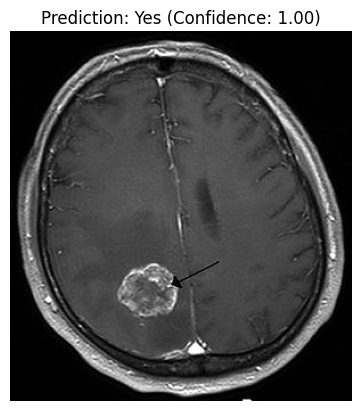

In [72]:

# Function to load and preprocess an image for prediction
def load_and_process_image(img_path, target_size=(240, 240)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to display an image along with its predicted class
def display_image_with_prediction(model, img_path):
    img_array = load_and_process_image(img_path)
    prediction = model.predict(img_array)[0, 0]

    # Display the image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

    # Display the prediction result
    if prediction > 0.5:
        plt.title(f'Prediction: Yes (Confidence: {prediction:.2f})')
    else:
        plt.title(f'Prediction: No (Confidence: {1 - prediction:.2f})')

    plt.axis('off')
    plt.show()

# Choose an image from the test set for visualization
sample_img_path = test_df['filename'].iloc[0]

# Display the image with the model's prediction
display_image_with_prediction(model, sample_img_path)
